# Exploration of languages in MUSE embeddings
In 2018, Facebook released a version of word embeddings that aligned all languages into a single embedding space, and in this notebook I will explore a bit about how language is represented in that space. If you aren't familiar with word embeddings, they are a way to represent words as numbers (or points in space), making them easier for computers to understand. For more about word embeddings, [this blog post by Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) is a good summary.

Most initial work on word embeddings focused on single languages, but parallel work focused on aligning word embeddings from multiple languages into the same space. This would hopefully yield some benefits, like:
* making translation easier
* reducing maintenance cost of maintaining word embeddings for each language
* allowing transfer of knowledge from high resource languages to low resource languages (e.g. English to Navajo)

Most approaches to this problem work by starting with bilingual dictionaries of words between languages (e.g. "cerveza <-> beer"), and using them as anchors to rotate one word embedding to match another. The Facebook paper used a more advanced version of this that incorporates adversarial learning. More importantly, for me, they released pre-trained, aligned word embeddings for 30 languages!

In this notebook, I am going to explore how language is represented in the MUSE embeddings. They key takeaways are:
* words that are more common have lower similarity across languages (e.g. "the" is less similar to articles in other languages than "enzyme")
* in the MUSE embeddings, languages' have a "direction," primarily found in these common words

To see the results, skip down to "Exploration of MUSE embedding"



## Setup:
First, mount files from Google drive:

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
folder_loc = r'/content/gdrive/My Drive/Colab Notebooks/data/token_embeddings/'

### Imports

In [34]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fs = 22
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fs}

matplotlib.rc('font', **font)
plt.rc('xtick', labelsize=fs-6)
plt.rc('ytick', labelsize=fs-6)

#### Helper function

In [0]:
def load_bilingual_df(bilingual_dict_loc:str, lang1:str, lang2: str, muse_model, word_count_df: pd.DataFrame):
  ''' Function to load a bilingual dictionary, and calculate metrics between words
      bilingual_dict_loc: location of bilingual dictionary
        -should have two columns of words, one for each language
      lang1/lang2: two-letter names of languages, e.g. "es"
      muse_model: gensim KeyedVector model for MUSE embedding
      word_count_df: pandas DF with two columns, "word" and "count"
  '''
  print('Loading dictionary')
  bi_dict = (pd.read_csv(bilingual_dict_loc, delim_whitespace=True,
                        header = None, names = [lang1, lang2])
                .query(f'{lang1} != {lang2}'))
  # deduplicate words
  count1 = bi_dict[lang1].value_counts().reset_index().rename(columns = {lang1:f'{lang1}_count', 'index':lang1})
  count2 = bi_dict[lang2].value_counts().reset_index().rename(columns = {lang2:f'{lang2}_count', 'index':lang2})
  bi_dict = bi_dict.merge(count1, on = lang1).merge(count2, on=lang2)
  bi_dict[f'{lang1}_in_muse'] = bi_dict[lang1].apply(lambda row: row in muse_model)
  bi_dict[f'{lang2}_in_muse'] = bi_dict[lang2].apply(lambda row: row in muse_model)

  print('Calculating similarity for words in model')
  # get only words in the MUSE model
  simi_df = bi_dict.query(f'{lang1}_in_muse and {lang2}_in_muse')
  # calculate cosine similarity and merge back on
  simi_df['simi'] = simi_df.apply(lambda row: muse_model.similarity(row[lang1], row[lang2]), axis = 1 )
  simi_df = simi_df.merge(word_count_df, left_on=lang1, right_on='word', how='left')

  print('Calculating common language vector')
  common_word_diffs = []
  # get difference between words for pairs, and average that difference
  for index, row in simi_df.iterrows():
      common_word_diffs.append(muse_model[row[lang2]] - muse_model[row[lang1]] )
  common_word_diffs = np.array(common_word_diffs)
  common_direction = common_word_diffs.mean(axis = 0)
  
  # calculate similarity 
  simi_df['common_direction_simi'] = simi_df[lang2].apply(lambda row:cos_sim(muse_model[row], common_direction))

  # edit distance similarity
  simi_df['edit_similarity'] = simi_df.apply(lambda row: fuzz.ratio(row[lang1], row[lang2]), axis=1)

  return simi_df

## Exploration of MUSE embedding using English and Spanish
### Calculating similarity between bilingual word pairs
Before doing anything fancy, we can load a MUSE model, and look at how words are similar across languages.

In [38]:
%%time
muse_model = KeyedVectors.load_word2vec_format(r'/content/gdrive/My Drive/Colab Notebooks/data/token_embeddings/wiki.multi.en-es-fr-vi.vec')

CPU times: user 2min 25s, sys: 1.93 s, total: 2min 27s
Wall time: 2min 27s


First thing we can do is calculate the similarity for a few word pairs across Spanish and English, ranging from common to rare:

In [73]:
for word1, word2 in (['the', 'el'],
                     ['cerveza', 'beer'],
                     ['enzyme', 'enzima']):
  print(muse_model.similarity(word1, word2))

0.23508638
0.5158917
0.83669


For these three words, at least, the common words ("the", "beer") have lower similarity than the uncommon one.

To explore this more rigorously, we can look at word frequency across a larger set of words. The two most convenient sources of word frequency I found were from [Peter Norvig](https://norvig.com/ngrams/), and from the Colombian newspaper counter [Cavorite](http://ngrams.cavorite.com/). (I think) word frequency generally follows a power law, which can be seen in the example word counts below.

In [40]:
  norvig_df = pd.read_csv(folder_loc + 'norvig_word_counts.tsv', sep='\t',names = ['word', 'count'])
  cavorite_df = pd.read_csv(folder_loc + 'cavorite_word_counts_es.tsv', sep='\t', names = ['word', 'count'])
  norvig_df.iloc[0:9000:2000,:]

,word,count
0,the,23135851162
2000,professor,40572636
4000,adoption,17860735
6000,pixels,10381558
8000,refurbished,7018259


With the word count file, we can combine that with Facebook's bilingual dictionary, and calculate word similarity for pairs of words using a helper function.

In [42]:
en_es_df = load_bilingual_df(folder_loc + 'bilingual_dictionaries/en-es.txt', 'en', 'es',muse_model, norvig_df)

Loading dictionary
Calculating similarity for words in model
Calculating common language vector


Below is an example of what the data looks like. The columns are:
* `en/es`: word pair in English and Spanish
* `en_count/es_count`: number of times the word appears in the bilingual dictionary
* `simi`: cosine similarity between this pair of words in the MUSE embedding space
* `count`: word count for language in first column (in this case, English word count)
* `common_direction_simi`: cosine similarity between word in second column, and the common difference of the words
* `edit_similarity`: fuzzywuzzy `ratio` edit similarity between the pair of words

In [75]:
en_es_df.drop(columns = ['en_in_muse', 'es_in_muse', 'word']).sample(3)

,en,es,en_count,es_count,simi,count,common_direction_simi,edit_similarity
30818,lefty,zurdo,1,1,0.468547,978333.0,0.030474,0
24740,ruthless,despiadados,3,2,0.672333,1014804.0,0.018294,32
23082,ignorant,ignorante,2,1,0.747805,2724458.0,0.037379,94


### Word frequency versus similarity
Now that we have word frequency data, we can compare word frequency to the similarity between words. In this graph, the x-axis is the word frequency of the English word (log-scale); the y-axis is the cosine similarity between the English word and the Spanish word.

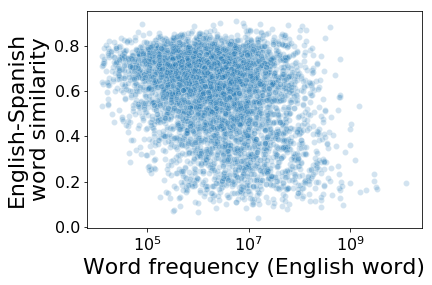

In [48]:
sns.scatterplot(x="count", y="simi", data=en_es_df.sample(5000), alpha = 0.2)
plt.xscale('log')
plt.xlabel('Word frequency (English word)')
plt.ylabel('English-Spanish\nword similarity');

Looking at the y-axis, you can see a majority of words have cosine similarity above 0.5. However, there is a large minority of words that have similarity < 0.3, and these words tend to be the higher frequency words. We can do a simple aggregation to show this:


In [51]:
print('Median word frequency for high similarity words: {}'.format(en_es_df.query('simi > 0.5')['count'].median()))
print('Median word frequency for low similarity words:  {}'.format(en_es_df.query('simi < 0.3')['count'].median()))

Median word frequency for high similarity words: 1457470.5
Median word frequency for low similarity words:  8191578.5


I have only read popular linguistic books, but it is my understanding that common words' meaning are more malleable, and change over time. For example, the word "grow" can refer to plants, animals, cities, or careers. In contrast, "enzyme" refers specifically to a protein with certain properties. Given this, perhaps the lower similarity of common words is due to their poly-semous nature.

### Language is a vector
Looking at the above graph, one idea I had is that the common words might all be pointing in the same direction. To test this idea, I did the following:
1. For each word pair, subtracted the embedding for the Spanish word from the embedding for the English word
2. Averaged all of these difference vectors together to get the "common" difference vector between English and Spanish words
3. Calculated the similarity between each Spanish word embedding, and this common difference vector.

In the plot below, each point is a word pair; the x-axis is again English word frequency; and the y-axis is the similarity between the Spanish word embedding and the common difference vector.

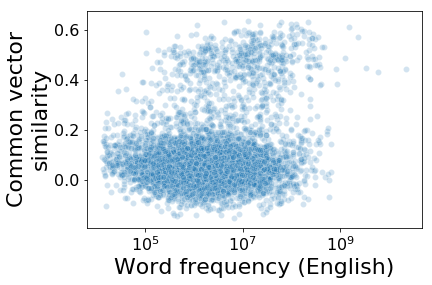

In [76]:
sns.scatterplot(x="count", y="common_direction_simi", data=en_es_df.sample(5000), alpha = 0.2)
plt.xscale('log')
plt.xlabel('Word frequency (English)')
plt.ylabel('Common vector\nsimilarity');

From this graph, we can see there are two types of words in the MUSE embedding: words that are somewhat similar to the common difference vector (0.4-0.6); and words that generally are not (< 0.3). High frequency words also had higher common vector similarity. My hypothesis that common words are all aligned in the same direction has at least some support.

MUSE embeddings are based on Facebook's FastText character-level embeddings. To see if character-level similarity was influencing the word embeddings after alignment, I plotted the same scatterplot as above, except this time I color-coded each word-pair with it's character similarity (where 100=identical). While there might be some trend for high character-similarity words to have less in common with the language direction, it does not seem like a strong bias.

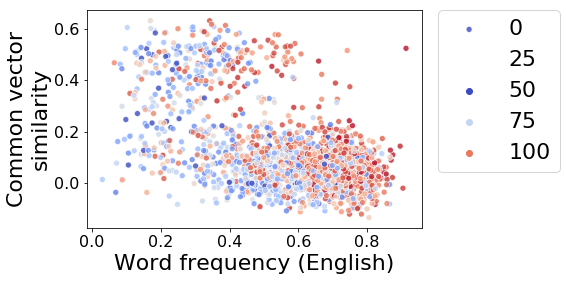

In [77]:
cmap = sns.cubehelix_palette(dark=.3, light=0.9, as_cmap=True)
sns.scatterplot(x="simi", y="common_direction_simi", hue="edit_similarity",
                data = en_es_df.sample(2000),  alpha = 0.8, palette = 'coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels = np.arange(0, 101, 25));
plt.xlabel('Word frequency (English)')
plt.ylabel('Common vector\nsimilarity');

## Replication in other languages
All the analysis above was for Spanish and English. If my hypotheses are correct, we should see similar behaviour for other languages. So I downloaded MUSE embeddings for French and Vietnamese to compare with English; and I also looked at the Spanish-French pair.

In [55]:
en_fr_df = load_bilingual_df(folder_loc + 'bilingual_dictionaries/en-fr.txt', 'en', 'fr', muse_model, norvig_df)
en_vi_df = load_bilingual_df(folder_loc + 'bilingual_dictionaries/en-vi.txt', 'en', 'vi', muse_model, norvig_df)
es_fr_df = load_bilingual_df(folder_loc + 'bilingual_dictionaries/es-fr.txt', 'es', 'fr', muse_model, cavorite_df)

Loading dictionary
Calculating similarity for words in model
Calculating common language vector
Loading dictionary
Calculating similarity for words in model
Calculating common language vector
Loading dictionary
Calculating similarity for words in model
Calculating common language vector


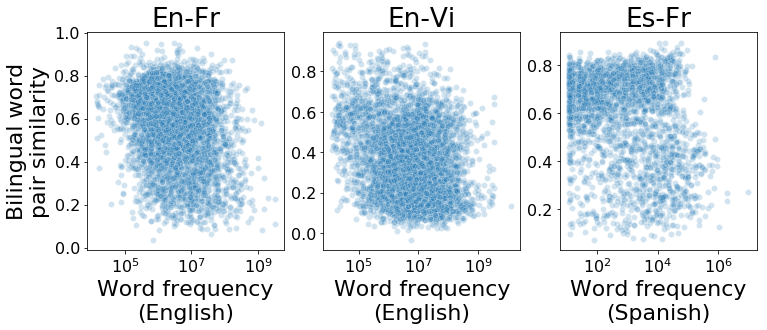

In [68]:
fig, axes = plt.subplots(1,3, figsize= [12, 4])
sns.scatterplot(x="count", y="simi", data=en_fr_df.sample(5000), alpha = 0.2, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_ylabel('Bilingual word\npair similarity')
axes[0].set_xlabel('Word frequency\n(English)')
axes[0].set_title('En-Fr')

sns.scatterplot(x="count", y="simi", data=en_vi_df.sample(5000), alpha = 0.2, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word frequency\n(English)')
axes[1].set_title('En-Vi')
axes[1].set_ylabel('')

sns.scatterplot(x="count", y="simi", data=es_fr_df.sample(5000), alpha = 0.2, ax=axes[2])
axes[2].set_xscale('log')
axes[2].set_title('Es-Fr')
axes[2].set_ylabel('')
axes[2].set_xlabel('Word frequency\n(Spanish)');

For each language pair, we see similar results to English-Spanish: more common words tend to have lower similarity across languages. For Spanish-French, there does seem to be higher cross-language similarity, perhaps due to them both being Romance languages.

We can also look at the common language direction plots across languages:

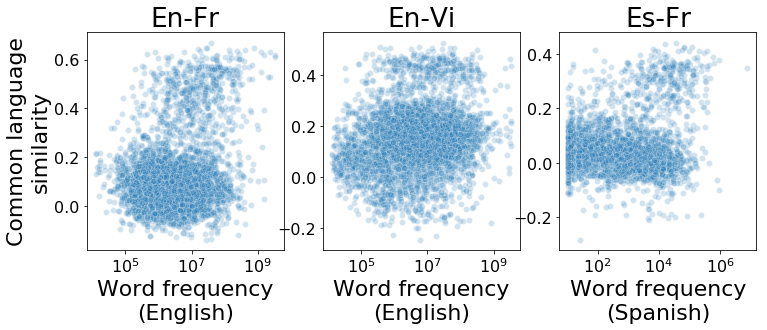

In [78]:
fig, axes = plt.subplots(1,3, figsize= [12, 4])
sns.scatterplot(x="count", y="common_direction_simi", data=en_fr_df.sample(5000), alpha = 0.2, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_ylabel('Common language\nsimilarity')
axes[0].set_xlabel('Word frequency\n(English)')
axes[0].set_title('En-Fr')

sns.scatterplot(x="count", y="common_direction_simi", data=en_vi_df.sample(5000), alpha = 0.2, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word frequency\n(English)')
axes[1].set_title('En-Vi')
axes[1].set_ylabel('')

sns.scatterplot(x="count", y="common_direction_simi", data=es_fr_df.sample(5000), alpha = 0.2, ax=axes[2])
axes[2].set_xscale('log')
axes[2].set_title('Es-Fr')
axes[2].set_ylabel('')
axes[2].set_xlabel('Word frequency\n(Spanish)');

For these languages, we see the same pattern as before: there are a set of words which are similar to the common language vector; and these words tend to be more common that the other words. For Vietnamese, there also might be a third cluster at low English word frequency.

## Conclusion
In this notebook I looked at how words are represented across language in Facebook's MUSE embedding. I found that more common words have lower similarity across languages than less common words. This could cause problems in usage if you make the assumption words across languages will be similar. For example, antonyms for common words will be more similar than cross-language synonyms.

The second thing I found was that, even after alignment (or perhaps due to alignment), language is present in embeddings as a direction. This is particularly true for more common words. This might be a useful feature in multilingual environments, since it would allow models that consume these embeddings to implicitly know which language a word or sentence is coming from.